### Scrape the past year's prices (from June 7, 2023, to June 6, 2024) for all stocks in the Australian stock market.

In [1]:
import pandas as pd
import yfinance as yf
import time

# Load ASX listed companies data
file_path = 'ASX_Listed_Companies_25-11-2024_02-49-49_AEDT.csv'
asx_companies = pd.read_csv(file_path)

# Extract ASX stock codes (add suffix ".AX" for yfinance fetching)
asx_companies['Ticker'] = asx_companies['ASX code'] + ".AX"

# Set time range
start_date = "2023-06-07"
end_date = "2024-06-06"

# Define function to fetch historical stock prices for a single stock
def fetch_stock_data(ticker, start_date, end_date):
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        if not data.empty:
            data['Ticker'] = ticker
            print(f"Successfully fetched data for {ticker}")
            return data
        else:
            print(f"No historical data for stock {ticker}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
        return pd.DataFrame()

# Fetch data for all stocks
all_data = []
for ticker in asx_companies['Ticker']:
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    if not stock_data.empty:
        all_data.append(stock_data)
    time.sleep(1)  # Limit request frequency to avoid being banned

# Combine all data and save to CSV file
if all_data:
    combined_data = pd.concat(all_data)
    combined_data.to_csv("ASX_Historical_Prices_2023-06-07_to_2024-06-06.csv", index=False)
    print("All stock data has been saved to ASX_Historical_Prices_2023-06-07_to_2024-06-06.csv")
else:
    print("Failed to fetch any data successfully")


Successfully fetched data for 14D.AX
Successfully fetched data for 1AD.AX
Successfully fetched data for 1AE.AX
Successfully fetched data for 1AI.AX
Successfully fetched data for 1CG.AX


$1MC.AX: possibly delisted; no price data found  (1d 2023-06-07 -> 2024-06-06) (Yahoo error = "Data doesn't exist for startDate = 1686060000, endDate = 1717596000")


No historical data for stock 1MC.AX
Successfully fetched data for 1TT.AX
Successfully fetched data for 29M.AX
Successfully fetched data for 360.AX
Successfully fetched data for 3DA.AX
Successfully fetched data for 3DP.AX


KeyboardInterrupt: 

### Convert to Excel format, including the columns: "Stock_Code," "Date," "Price," "52 Weeks range," "52 range top," "%diff," and "1 Year Plot."

In [ ]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.drawing.image import Image

# Load data file
data_path = "ASX_Historical_Prices_2023-06-07_to_2024-06-06.csv"
historical_data = pd.read_csv(data_path)

# Determine the trading date range
start_date = pd.Timestamp("2023-06-07")
end_date = pd.Timestamp("2024-06-06")
date_range = pd.date_range(start=start_date, end=end_date, freq="B")  # Business Days

# Get the list of stock tickers
tickers = historical_data["Ticker"].unique()

# Assign trading dates to each stock (allow records less than 253)
all_stocks_data = []
for ticker in tickers:
    stock_data = historical_data[historical_data["Ticker"] == ticker].reset_index(drop=True)
    
    # If the record count is less than 253, fill in missing dates
    if len(stock_data) <= len(date_range):
        stock_data["Date"] = pd.date_range(start=start_date, periods=len(stock_data), freq="B")
        all_stocks_data.append(stock_data)
    else:
        print(f"The data record count for stock {ticker} exceeds trading days, skipping...")

# Combine all stock data
if all_stocks_data:
    historical_data_with_dates = pd.concat(all_stocks_data, ignore_index=True)
else:
    raise ValueError("All stock data is incomplete, unable to proceed.")

# Get the Close value for the target date, or fallback to the nearest trading day
def get_latest_close(stock_data, target_date):
    """Get the closing price for the target date, fallback to the nearest valid trading day if missing"""
    if target_date in stock_data["Date"].values:
        return stock_data.loc[stock_data["Date"] == target_date, "Close"].values[0]
    else:
        # If the target date has no data, fallback to the most recent trading day
        available_data = stock_data[stock_data["Date"] <= target_date]
        if not available_data.empty:
            return available_data.iloc[-1]["Close"]
        return None  # Return None if no data is available

# Target date and time range
target_date = pd.Timestamp("2024-06-06")

# Store results
results = []

# Iterate through each stock to calculate target fields
for ticker in tickers:
    stock_data = historical_data_with_dates[historical_data_with_dates["Ticker"] == ticker]

    # Check if data is available
    if stock_data.empty:
        print(f"The data for stock {ticker} is empty, skipping...")
        continue

    # Calculate 52 Weeks range and 52 range top
    min_price = stock_data["Close"].min()
    max_price = stock_data["Close"].max()
    
    # Get the Close value for the target date
    latest_close = get_latest_close(stock_data, target_date)

    # Calculate %diff
    diff_percentage = None
    if latest_close is not None and max_price > 0:
        diff_percentage = (latest_close - max_price) / max_price * 100

    # Store results
    results.append({
        "Stock_Code": ticker,
        "Date": target_date.strftime("%Y-%m-%d"),
        "Price": latest_close,
        "52 Weeks range": f"({min_price:.2f}, {max_price:.2f})",
        "52 range top": max_price,
        "%diff": f"{diff_percentage:.2f}%" if diff_percentage is not None else "N/A"
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Directly use pre-generated image paths
def get_image_path(ticker):
    """Return the path to the pre-generated image for the stock"""
    return f"{ticker}_1_year_plot.png"

# Step 3: Combine data and charts into Excel
excel_file = "ASX_Formatted_Output_With_Images.xlsx"
wb = Workbook()
ws = wb.active
ws.title = "ASX Data"

# Write headers
columns = ["Stock_Code", "Date", "Price", "52 Weeks range", "52 range top", "%diff", "1 Year Plot"]
ws.append(columns)

# Write data and dynamically adjust image insertion
row_index = 2  # Start writing data and images from row 2
for _, row in results_df.iterrows():
    stock_code = row["Stock_Code"]
    excel_row = [
        row["Stock_Code"],
        row["Date"],
        row["Price"],
        row["52 Weeks range"],
        row["52 range top"],
        row["%diff"]
    ]
    ws.append(excel_row)
    
    # Add image
    chart_path = get_image_path(stock_code)
    try:
        img = Image(chart_path)
        img.anchor = f"G{row_index}"  # Insert image into column G, aligned with the current data row
        ws.add_image(img)
    except FileNotFoundError:
        print(f"Chart file {chart_path} for stock {stock_code} not found, skipping...")
    
    row_index += 1  # Move to the next row for both data and images

# Save Excel file
wb.save(excel_file)
print(f"Excel file saved to {excel_file}")



### Scrape the price for 2024-09-30 and merge the data.

In [ ]:
import pandas as pd
import yfinance as yf

# Step 1: Load ASX_Cleaned.xlsx and extract specific columns
def extract_start_price(input_file, output_csv):
    """从Excel中提取Stock_Code和Price列并保存为CSV"""
    asx_data = pd.read_excel(input_file, usecols=["Stock_Code", "Price"])
    asx_data.to_csv(output_csv, index=False)

# Step 2: Fetch End Prices from Yahoo Finance
def fetch_end_prices(input_csv, output_csv, output_excel, target_date="2024-09-30"):
    """从Yahoo Finance爬取股票在目标日期的收盘价，保存为CSV和Excel"""
    # Load start price data
    start_price_data = pd.read_csv(input_csv)
    stock_codes = start_price_data["Stock_Code"]
    
    # Initialize a list to store end prices
    end_prices = []
    
    for stock_code in stock_codes:
        try:
            # Fetch data for the target date
            data = yf.download(stock_code, start=target_date, end="2024-10-01", progress=False)
            close_price = data["Close"].iloc[0] if not data.empty else None
            end_prices.append(close_price)
        except Exception as e:
            print(f"Error fetching data for {stock_code}: {e}")
            end_prices.append(None)
    
    # Add end prices to the DataFrame
    start_price_data["End_Price"] = end_prices
    
    # Remove rows where End_Price is NaN
    filtered_data = start_price_data.dropna(subset=["End_Price"])
    
    # Save to CSV
    filtered_data.to_csv(output_csv, index=False)
    
    # Save to Excel
    filtered_data.to_excel(output_excel, index=False)
    return filtered_data

# Input and output file paths
input_excel = "ASX_Cleaned.xlsx"
start_price_csv = "200_Start_Price.csv"
end_price_csv = "200_Start_End_Price.csv"
end_price_excel = "200_Start_End_Price.xlsx"

# Execute steps
extract_start_price(input_excel, start_price_csv)
fetch_end_prices(start_price_csv, end_price_csv, end_price_excel)


### Change the table headers.

In [ ]:
import pandas as pd

# Load the CSV file
input_csv = "200_Start_End_Price.csv"
data = pd.read_csv(input_csv)

# Rename the column 'Price' to 'End_Price'
data.rename(columns={"Price": "Start_Price"}, inplace=True)

# Save the updated file
data.to_csv(input_csv, index=False)

print(f"Column renamed successfully. Updated file saved as {input_csv}.")


### Calculate simple return and log return.

In [ ]:
import pandas as pd
import numpy as np

# Step 1: Load 200_Start_End_Price.csv
input_csv = "200_Start_End_Price.csv"
data = pd.read_csv(input_csv)

# Step 2: Calculate Simple Return and Log Return
data["Simple_Return"] = (data["End_Price"] - data["Start_Price"]) / data["Start_Price"]
data["Log_Return"] = np.log(data["End_Price"] / data["Start_Price"])

# Step 3: Save the results to CSV and Excel
output_csv = "200_simple_log_return.csv"
output_excel = "200_simple_log_return.xlsx"

# Save to CSV
data.to_csv(output_csv, index=False)

# Save to Excel
data.to_excel(output_excel, index=False)


### Perform a one-sided t-test.

Market Start Price (2024-06-06): 8074.2998046875
Market End Price (2024-09-30): 8538.400390625
Market Simple Return: 0.057478740839926254
Market Log Return: 0.05588752851156739

One-Tailed T-Test Results:
Simple Return T-Statistic: 2.400446457304651, One-Tailed P-Value: 0.008650397651260484
Log Return T-Statistic: 1.3155030439788062, One-Tailed P-Value: 0.09493107254272218


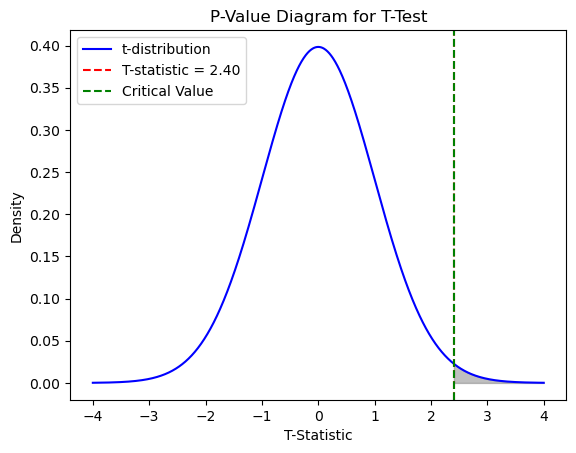

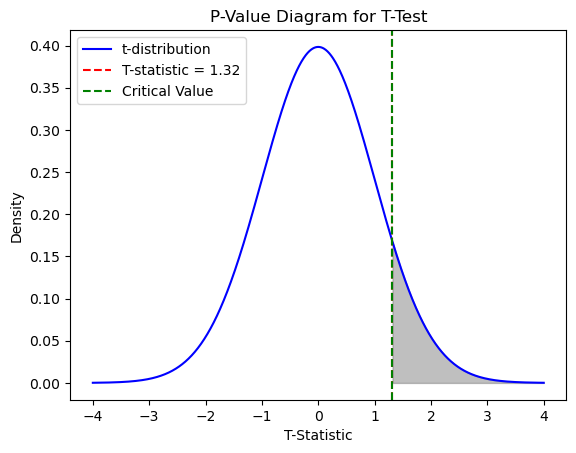

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import ttest_1samp

# Step 1: Load stock data
stock_data_file = "200_simple_log_return.csv"
stock_data = pd.read_csv(stock_data_file)

# Step 2: Fetch market data (^AORD) from Yahoo Finance
def fetch_market_data(ticker, start_date, end_date):
    """Fetch market data from Yahoo Finance and ensure Close prices are used"""
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if "Close" not in data.columns:
        raise ValueError("Close prices are not available in the downloaded data.")
    return data

# Fetch ^AORD data
market_ticker = "^AORD"
market_start_date = "2024-06-06"
market_end_date = "2024-10-01"  # Include 2024-09-30 data

market_data = fetch_market_data(market_ticker, market_start_date, market_end_date)

# Ensure Close prices are extracted for specific dates
def get_close_price(data, target_date):
    """Get the Close price on the target date or the nearest available trading day before it"""
    target_date = pd.Timestamp(target_date)
    if target_date in data.index:
        return data.loc[target_date, "Close"]
    else:
        available_dates = data.index[data.index <= target_date]
        if not available_dates.empty:
            closest_date = available_dates[-1]
            return data.loc[closest_date, "Close"]
        else:
            raise ValueError(f"No Close price data available for or before {target_date}.")

# Get start and end Close prices
market_start_price = get_close_price(market_data, market_start_date)
market_end_price = get_close_price(market_data, market_end_date)

# Step 3: Calculate market Simple Return and Log Return
market_simple_return = (market_end_price - market_start_price) / market_start_price
market_log_return = np.log(market_end_price / market_start_price)

# Step 4: Perform one-sample t-test (One-Tailed)
# Test for Simple Returns
t_stat_simple, p_value_simple = ttest_1samp(stock_data["Simple_Return"], market_simple_return)
one_tailed_p_value_simple = p_value_simple / 2 if t_stat_simple > 0 else 1 - (p_value_simple / 2)

# Test for Log Returns
t_stat_log, p_value_log = ttest_1samp(stock_data["Log_Return"], market_log_return)
one_tailed_p_value_log = p_value_log / 2 if t_stat_log > 0 else 1 - (p_value_log / 2)

# Step 5: Output results
print("Market Start Price (2024-06-06):", market_start_price)
print("Market End Price (2024-09-30):", market_end_price)
print("Market Simple Return:", market_simple_return)
print("Market Log Return:", market_log_return)
print("\nOne-Tailed T-Test Results:")
print(f"Simple Return T-Statistic: {t_stat_simple}, One-Tailed P-Value: {one_tailed_p_value_simple}")
print(f"Log Return T-Statistic: {t_stat_log}, One-Tailed P-Value: {one_tailed_p_value_log}")

import matplotlib.pyplot as plt
from scipy.stats import t

# Step 6: Create the P-Value Diagram
def plot_p_value_diagram(t_stat, df, p_value, tail="right"):
    """Plot the p-value diagram with rejection region shaded"""
    # Create an array of t-values for plotting
    t_values = np.linspace(-4, 4, 1000)
    pdf_values = t.pdf(t_values, df)  # Probability density function (PDF) of the t-distribution

    # Plot the t-distribution curve
    plt.plot(t_values, pdf_values, label="t-distribution", color='blue')

    # Shade the rejection region (gray area)
    if tail == "right":
        plt.fill_between(t_values, pdf_values, where=(t_values >= t_stat), color='gray', alpha=0.5)
    else:
        plt.fill_between(t_values, pdf_values, where=(t_values <= t_stat), color='gray', alpha=0.5)

    # Mark the critical value and the t-statistic
    plt.axvline(x=t_stat, color='red', linestyle='--', label=f"T-statistic = {t_stat:.2f}")
    plt.axvline(x=t.ppf(1 - p_value, df), color='green', linestyle='--', label="Critical Value")

    # Add labels and title
    plt.title("P-Value Diagram for T-Test")
    plt.xlabel("T-Statistic")
    plt.ylabel("Density")
    plt.legend()

    # Show the plot
    plt.show()

# Degrees of freedom for one-sample t-test
df_simple = len(stock_data["Simple_Return"]) - 1
df_log = len(stock_data["Log_Return"]) - 1

# Plot for Simple Return
plot_p_value_diagram(t_stat_simple, df_simple, one_tailed_p_value_simple)

# Plot for Log Return
plot_p_value_diagram(t_stat_log, df_log, one_tailed_p_value_log)



Get the weekly ^AORD and weekly average price for the top 200 companies

In [2]:
import pandas as pd
import yfinance as yf
import time

market_ticker = "^AORD"
# Create an empty DataFrame to store the data
AORD_close_data = pd.DataFrame()

start_date = '2024-06-06'
end_date = '2024-09-30'
# Fetch weekly close data for each stock symbol
stock_data = yf.download(market_ticker, start=start_date, end=end_date)
AORD_close_data[market_ticker] = stock_data['Close']
data = AORD_close_data[market_ticker]

data.to_csv("AORD_price.csv", index=False)
#print("All stock data has been saved to AORD_weekly_price.csv")

[*********************100%***********************]  1 of 1 completed


In [3]:
import pandas as pd
import yfinance as yf
import time

# Load ASX listed companies data
file_path = '200_stocks.csv'
asx_companies = pd.read_csv(file_path)

# Extract ASX stock codes (add suffix ".AX" for yfinance fetching)
asx_companies['Ticker'] = asx_companies['ASX code']

# Set time range
start_date = "2024-06-06"
end_date = "2024-09-30"

# Define function to fetch historical stock prices for a single stock
def fetch_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if not data.empty:
            all_data[ticker] = data['Close'] 
            print(f"Successfully fetched data for {ticker}")
            return all_data
        else:
            print(f"No historical data for stock {ticker}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
        return pd.DataFrame()

# Fetch data for all stocks
all_data = pd.DataFrame()
data_mean = []
for ticker in asx_companies['Ticker']:
    all_data = fetch_stock_data(ticker, start_date, end_date)
    
    #print(all_data)
    #if not all_data.empty:
       #weak_mean.append(all_data['Average'])
    #print(all_data, weak_mean)
    
    time.sleep(1)  # Limit request frequency to avoid being banned

all_data['Average'] = all_data.mean(axis=1)
data_mean.append(all_data['Average'])
#print(weak_mean)
# Combine all data and save to CSV file
if data_mean:
    combined_data = pd.concat(data_mean)
    combined_data.to_csv("ASX_price.csv", index=False)
    print("All stock data has been saved to ASX_price.csv")
else:
    print("Failed to fetch any data successfully")

[*********************100%***********************]  1 of 1 completed


Successfully fetched data for A3D.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for ACP.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for ATR.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for BOL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for BRE.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for CBA.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for CCO.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for CE1.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for COV.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for DRO.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for DXN.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for EGL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for EQT.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for EVO.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for FGG.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for FHE.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for FPH.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for FSF.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for GDG.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for GMG.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for GNC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for HMC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for HUB.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for HYT.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for IFT.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for JAT.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for LTP.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for MFF.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for MYS.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for NAB.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for NGI.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for OIL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for PGF.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for PME.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for QUB.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for RC1.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for RPL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for SUM.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for TNE.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for URW.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for VBC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for VGL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for WAA.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for WCN.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for BEN.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for GDC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for SNL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for WGB.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for GVF.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for QRI.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for PSQ.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for PXA.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for ALQ.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for TCF.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for DUI.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for ANZ.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for LSF.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for LGI.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for PMC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for PL8.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for VG1.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for KAT.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for FGX.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for TRA.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for AMC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for PBH.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for EZZ.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for RG8.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for AUI.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for LCE.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for GCI.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for QBE.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for DJW.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for ELS.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for NWS.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for KSL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for AIQ.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for IGNDA.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for TDO.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for MQG.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for AAC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for BGA.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for BWP.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for WAR.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for WBC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for OFX.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for ALL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for GFL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for NXT.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for KKC.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for COS.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for MAH.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for MXT.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for RYD.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for FRI.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for RUL.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for IAG.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for ORG.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for ORI.AX


[*********************100%***********************]  1 of 1 completed


Successfully fetched data for DXI.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for TLX.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for GIB.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for PIC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for AUB.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for PNR.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for VVA.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for MDR.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for QOR.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for GDI.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for NTU.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for RF1.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for A2M.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CDP.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for TLC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for PGC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for SUN.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for GTK.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CTE.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for WQG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CEN.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for WEB.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for HPI.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CAR.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for TOP.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CDA.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for DXB.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for SVM.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for S32.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for APZ.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for PNI.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for DBI.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for GNP.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for AMH.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for NWL.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for PNC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for BGP.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for ARG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for PRO.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for PEX.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for MOT.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for IPL.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for LSX.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for WAT.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CIN.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for SRG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CVL.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for HM1.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for DXC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for MWY.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for SHA.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for REA.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for EGH.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for MEC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for ACR.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for MAQ.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for TWR.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for FPC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for LAM.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for LPE.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for ECP.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for WHC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for BFG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for BOQ.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CU6.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for AII.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for GSS.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CD3.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for GEM.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for MMI.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for AAP.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for SEG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for MEZ.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for MAU.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for ARF.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CHW.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for WHF.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for TTT.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for SXE.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for BIS.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for NGE.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for SGLLV.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for WTC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for NWH.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for RDX.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for WAF.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for TPC.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for BKI.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for APW.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for OPH.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for NWSLV.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for RSG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for AFI.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for HDN.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for EEG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for GQG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for EBG.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CBO.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for DOW.AX


[*********************100%***********************]  1 of 1 completed
/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[ticker] = data['Close']


Successfully fetched data for CAM.AX
[Date
2024-06-06     9.607646
2024-06-07     9.588839
2024-06-11     9.537990
2024-06-12     9.541258
2024-06-13     9.594276
                ...    
2024-09-23    10.616221
2024-09-24    10.722325
2024-09-25    10.491216
2024-09-26    10.656239
2024-09-27    10.689193
Name: Average, Length: 81, dtype: float64]
All stock data has been saved to ASX_price.csv


/var/folders/mb/34z82c2579x79_xxtnfk70200000gn/T/ipykernel_76375/3456026219.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['Average'] = all_data.mean(axis=1)


In [40]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

#Set the Y and X for the regression
Y = AORD_close_data[[market_ticker]]
X = all_data[['Average']]

#print(Y, X)

#Do the model fitting
model = LinearRegression()
model.fit(X, Y)

#Find the coefficients
coef = model.coef_[0]
intercept = model.intercept_
print('Y =', intercept,' + ',coef, 'X')



# Perform ANOVA for the regression
#anova_table = sm.stats.anova_lm(model2)
#print("\nANOVA Table:")
#print(anova_table)

mean_y = np.mean(AORD_close_data[[market_ticker]])

#Calculate total sum of squares (SST)
sst = np.sum((AORD_close_data['^AORD'] - mean_y) ** 2)

#Calculate regression sum of squares (SSR)
ssr = np.sum((coef * all_data['Average'] + intercept - mean_y) ** 2)

#Calculate residual sum of squares (SSE)
sse = sst - ssr

#Calculate degrees of freedom
n = len(AORD_close_data['^AORD'])
df_reg = 1 
df_resid = n - 2

#Calculate mean squares
ms_reg = ssr / df_reg 
ms_resid = sse / df_resid

#Calculate F-statistic
f_statistic = ms_reg / ms_resid

#Calculate p-value
p_value = stats.f.sf(f_statistic, df_reg, df_resid)


anova_table = pd.DataFrame({ 'Source': ['Regression', 'Residual', 'Total'], 'Degrees of Freedom': [df_reg, df_resid, n-1], 'Sum of Squares': [ssr, sse, sst], 'Mean Square': [ms_reg, ms_resid, ''], 'F-statistic': [f_statistic, '', ''], 'p-value': [p_value, '', ''] })
print("ANOVA Table:") 
print(anova_table)
print('P-value:', p_value)


#Using another model fitting method of OLS
X = sm.add_constant(all_data[['Average']])
Y = AORD_close_data[[market_ticker]]
model2 = sm.OLS(Y, X).fit()

# Get the R-squared value
r_squared = model2.rsquared
print("R-squared:", r_squared)

Y = [4452.80802554]  +  [368.93711919] X
ANOVA Table:
       Source  Degrees of Freedom  Sum of Squares     Mean Square F-statistic  \
0  Regression                   1    1.452167e+06  1452166.761213  292.772191   
1    Residual                  79    3.918445e+05     4960.057019               
2       Total                  80    1.844011e+06                               

  p-value  
0     0.0  
1          
2          
P-value: 2.7072167074258093e-28
R-squared: 0.7875042784215807
